In [56]:
import tensorflow as tf
import numpy as np
import os

In [57]:
dataset_dir = 'data/toy_dataset'
dry_audio_dir = os.path.join(dataset_dir, 'input/dry')
wet_audio_dir = os.path.join(dataset_dir, 'input/wet')
target_dir = os.path.join(dataset_dir, 'target')

audio_extension = '.wav'
target_extension = '.npy'

In [58]:
dry_audio_files = [os.path.join(dry_audio_dir, filename) for filename in os.listdir(dry_audio_dir) if filename.endswith(audio_extension)]
wet_audio_files = [os.path.join(wet_audio_dir, filename) for filename in os.listdir(wet_audio_dir) if filename.endswith(audio_extension)]
target_files = [os.path.join(target_dir, filename) for filename in os.listdir(target_dir) if filename.endswith(target_extension)]


In [59]:
dry_audio_files.sort()
wet_audio_files.sort()
target_files.sort()


In [95]:
def load_audio(file_path):
    audio = tf.io.read_file(file_path)
    audio = tf.audio.decode_wav(audio, desired_channels=1).audio
    return audio

def load_target(file_path):
    return tf.convert_to_tensor(np.load(file_path), dtype=tf.float32)

In [96]:
dry_tensors = [load_audio(file) for file in dry_audio_files]
wet_tensors = [load_audio(file) for file in wet_audio_files]
target_tensors = [load_target(file) for file in target_files]

In [100]:
dataset = tf.data.Dataset.from_tensor_slices((dry_tensors, wet_tensors, target_tensors))

In [101]:
# Sanity check
num_elements = 3
for data in dataset.take(num_elements):
    dry_audio, wet_audio, target = data
    print("Dry audio shape:", dry_audio.shape)
    print("Wet audio shape:", wet_audio.shape)
    print("Target:", target)
    print()


Dry audio shape: (44100, 1)
Wet audio shape: (44100, 1)
Target: tf.Tensor([100.    0.2], shape=(2,), dtype=float32)

Dry audio shape: (44100, 1)
Wet audio shape: (44100, 1)
Target: tf.Tensor([100.    0.2], shape=(2,), dtype=float32)

Dry audio shape: (44100, 1)
Wet audio shape: (44100, 1)
Target: tf.Tensor([100.    0.2], shape=(2,), dtype=float32)



In [131]:
import librosa
def mel(dry_audio, wet_audio, target):
    def mel_transform(dry_audio, wet_audio):
        # Compute mel spectrogram using librosa
        dry_mel = librosa.feature.melspectrogram(dry_audio, sr=44100)
        wet_mel = librosa.feature.melspectrogram(wet_audio, sr=44100)

        # Convert mel spectrograms to logarithmic scale
        dry_mel = librosa.power_to_db(dry_mel, ref=np.max)
        wet_mel = librosa.power_to_db(wet_mel, ref=np.max)

        return dry_mel, wet_mel

    # Apply mel transform using tf.numpy_function
    dry_mel, wet_mel = tf.numpy_function(mel_transform, [dry_audio, wet_audio], [tf.float32, tf.float32])

    return dry_mel, wet_mel, target

In [140]:
# TODO: Preferably, do this before creating the dataset object to avoid recalculating the mels every time the dataset object is manipulated
mel_dataset = dataset.map(lambda x, y, z: mel(x, y, z))

In [142]:
for data in mel_dataset.take(1):
    dry_audio, wet_audio, target = data
    print("Dry audio shape:", dry_audio.shape)
    print("Wet audio shape:", wet_audio.shape)
    print("Target:", target)
    print()

Dry audio shape: (44100, 128, 1)
Wet audio shape: (44100, 128, 1)
Target: tf.Tensor([100.    0.2], shape=(2,), dtype=float32)



(128, 44100)
(128, 44100)


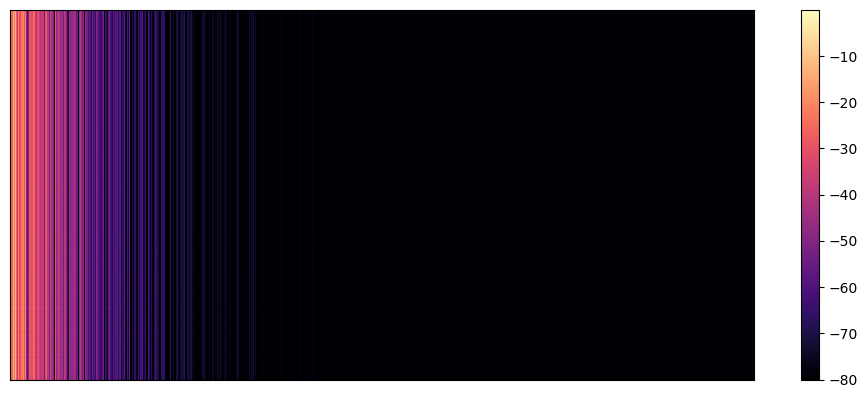

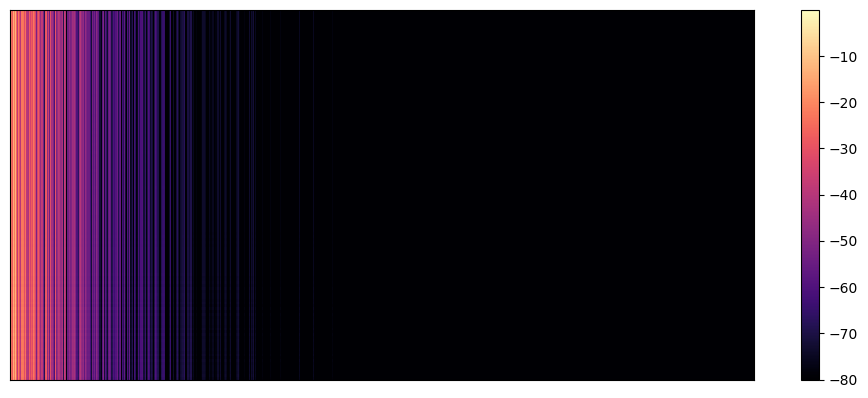

In [159]:
import matplotlib.pyplot as plt, librosa.display
# Visualize the mel spectrograms for the first element of the dataset
for data in mel_dataset.take(1):
    dry_mel, wet_mel, target = data
    
    # Squeeze the channel dimension of mel spectrograms
    dry_mel = tf.transpose(tf.squeeze(dry_mel, axis=-1))
    print(dry_mel.shape)
    wet_mel = tf.transpose(tf.squeeze(wet_mel, axis=-1))
    print(wet_mel.shape)
    
    plt.figure().set_figwidth(12)
    librosa.display.specshow(
        np.asarray(dry_mel),
        sr=44100,
        hop_length=512,
        n_fft=2048
    )
    plt.colorbar()
    plt.show()
    plt.figure().set_figwidth(12)
    librosa.display.specshow(
        np.asarray(wet_mel),
        sr=44100,
        hop_length=512,
        n_fft=2048
    )
    plt.colorbar()
    plt.show()

In [221]:
# Split the dataset into train and test sets
x, y = [], []
for dry, wet, target in dataset:
    concatenated_features = tf.concat([dry, wet], axis=-1)
    x.append(concatenated_features)
    y.append(target)

train_x, train_y = x, y
test_x = train_x[int(0.8 * len(train_x)):]
test_y = train_y[int(0.8 * len(train_y)):]
train_x = tf.stack(train_x)
train_y = tf.stack(train_y)


In [224]:
# Verify the shapes of train_x and train_y
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)

# Reshape train_x if needed to match the model's input shape
train_x = np.reshape(train_x, (train_x.shape[0], -1))
print("Reshaped train_x:", train_x.shape)

# Verify the shapes again
print("Updated train_x shape:", train_x.shape)
print("Updated train_y shape:", train_y.shape)

# Define the model architecture
dim = train_x.shape[1:]
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=dim),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2)  # Output layer for w parameter
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

train_x shape: (50, 88200)
train_y shape: (50, 2)
Reshaped train_x: (50, 88200)
Updated train_x shape: (50, 88200)
Updated train_y shape: (50, 2)


In [225]:
# Train the model
epochs = 100
model.fit(x=train_x, y=train_y, validation_split=0.2, epochs=epochs)

Epoch 1/100
2/2 [==============================] - 1s 248ms/step - loss: 4997.7798 - mae: 50.0807 - val_loss: 4971.9463 - val_mae: 50.0100
Epoch 2/100
2/2 [==============================] - 0s 51ms/step - loss: 4969.1255 - mae: 50.0064 - val_loss: 4943.1221 - val_mae: 49.9771
Epoch 3/100
2/2 [==============================] - 0s 50ms/step - loss: 4940.0742 - mae: 49.9745 - val_loss: 4912.4229 - val_mae: 49.9421
Epoch 4/100
2/2 [==============================] - 0s 46ms/step - loss: 4909.2803 - mae: 49.9357 - val_loss: 4880.5288 - val_mae: 49.8766
Epoch 5/100
2/2 [==============================] - 0s 52ms/step - loss: 4877.1973 - mae: 49.8694 - val_loss: 4846.7217 - val_mae: 49.8023
Epoch 6/100
2/2 [==============================] - 0s 45ms/step - loss: 4843.1914 - mae: 49.7941 - val_loss: 4810.9053 - val_mae: 49.7185
Epoch 7/100
2/2 [==============================] - 0s 46ms/step - loss: 4807.1670 - mae: 49.7094 - val_loss: 4772.9795 - val_mae: 49.6248
Epoch 8/100
2/2 [================